In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""

Improvements include:
    - Configurable noise filtering using wavelet transform and FFT (plus additional SMA feature).
    - An improved trading environment with risk management (transaction cost & slippage) and expanded observation space.
    - Basic logging for better traceability.
    - More robust hyperparameter evaluation (averaging over episodes).
    - Modular design for easier maintenance.
    
Required packages:
    numpy, pandas, matplotlib, gym, torch, pywavelets, scipy, stable-baselines3, bayesian-optimization, deap, requests
"""

import warnings
warnings.filterwarnings('ignore')

import os
import time
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import pywt  # For wavelet transforms
from scipy.fft import fft, ifft
from stable_baselines3 import PPO
from bayes_opt import BayesianOptimization
from deap import base, creator, tools, algorithms
import random
import requests

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)


def load_data(cache_file="binance_data.csv", symbol='BTCUSDT', interval='1m', limit=5000, max_retries=3):
    """
    Load data from Binance API with caching and robust error handling.
    If cache_file exists, load data from it.
    """
    if os.path.exists(cache_file):
        logger.info("Loading data from cache file: %s", cache_file)
        data = pd.read_csv(cache_file, parse_dates=['timestamp'], index_col='timestamp')
        return data

    url = "https://api.binance.com/api/v3/klines"
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': limit
    }
    retries = 0
    while retries < max_retries:
        try:
            response = requests.get(url, params=params, timeout=10)
            if response.status_code == 200:
                data_json = response.json()
                data = pd.DataFrame(
                    data_json,
                    columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 
                             'close_time', 'quote_asset_volume', 'number_of_trades', 
                             'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
                )
                data = data[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
                data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
                data.set_index('timestamp', inplace=True)
                data = data.astype(float)
                data = data.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume'})
                data.to_csv(cache_file)
                logger.info("Data fetched and cached to %s", cache_file)
                return data
            else:
                logger.error("Error fetching data: %s, %s", response.status_code, response.text)
        except Exception as e:
            logger.error("Exception occurred: %s", e)
        retries += 1
        time.sleep(2)
    raise Exception("Failed to load data after several retries.")


def noise_filtering(data, wavelet='db1', level=2, fft_cutoff=0.1, plot=True):
    """
    Apply noise filtering to the 'Close' price using wavelet transform and FFT.
    Also calculates a Simple Moving Average (SMA) for additional features.
    """
    signal = data['Close'].values

    if plot:
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(data['Close'], label='Original Signal', color='blue')
        plt.title('Original Close Price')
        plt.xlabel('Time')
        plt.ylabel('Close Price')
        plt.legend()

    # Wavelet decomposition using the specified wavelet and level
    coeff = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeff[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeff_filtered = [pywt.threshold(c, value=uthresh, mode='soft') for c in coeff]
    filtered_signal = pywt.waverec(coeff_filtered, wavelet)

    # FFT filtering: remove high-frequency components
    fft_coeff = fft(filtered_signal)
    freq = np.fft.fftfreq(len(filtered_signal))
    fft_coeff[np.abs(freq) > fft_cutoff] = 0
    filtered_signal_fft = np.fft.ifft(fft_coeff).real

    if plot:
        plt.subplot(3, 1, 2)
        plt.plot(filtered_signal, label='Filtered Signal (Wavelet)', color='green')
        plt.title('Filtered Signal using Wavelet')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(filtered_signal_fft, label='Filtered Signal (FFT)', color='red')
        plt.title('Filtered Signal using FFT')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()

        plt.tight_layout()
        plt.show()

    data['Close_filtered'] = filtered_signal_fft

    # Compute Simple Moving Average (SMA) with window=5 as an additional feature
    data['SMA'] = data['Close_filtered'].rolling(window=5, min_periods=1).mean()

    return data


class FeatureExtractor(nn.Module):
    """
    Hybrid feature extraction model combining CNN, LSTM, and Transformer Encoder.
    Although not directly integrated in the TradingEnv, this model can be used
    to extract predictive features from time-series data.
    """
    def __init__(self, input_dim, cnn_channels, lstm_hidden_size, transformer_dim, nhead, num_transformer_layers):
        super(FeatureExtractor, self).__init__()
        # CNN for local feature extraction (1D convolution)
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=cnn_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=cnn_channels, out_channels=cnn_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )
        # LSTM for capturing sequential dependencies
        self.lstm = nn.LSTM(input_size=cnn_channels, hidden_size=lstm_hidden_size, batch_first=True)
        # Fully connected layer to map LSTM output to transformer dimension
        self.fc = nn.Linear(lstm_hidden_size, transformer_dim)
        # Transformer Encoder for global dependency modeling
        encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)

    def forward(self, x):
        # Rearrange for CNN: (batch, features, seq_len)
        x_cnn = x.transpose(1, 2)
        cnn_out = self.cnn(x_cnn)
        # Rearrange back: (batch, seq_len, channels)
        cnn_out = cnn_out.transpose(1, 2)
        # LSTM processing
        lstm_out, _ = self.lstm(cnn_out)
        # Map LSTM output to transformer dimension
        fc_out = self.fc(lstm_out)
        # Transformer expects input shape: (seq_len, batch, d_model)
        transformer_in = fc_out.transpose(0, 1)
        transformer_out = self.transformer(transformer_in)
        # Aggregate transformer outputs (mean over sequence length)
        features = transformer_out.mean(dim=0)
        return features  # Shape: (batch, transformer_dim)


class TradingEnv(gym.Env):
    """
    Custom trading environment for simulating BTC/USD trading with risk management and additional features.
    Observations: Sliding window of normalized filtered closing prices and SMA.
    Actions: 0 = Hold, 1 = Buy, 2 = Sell.
    Reward: Profit/loss realized after accounting for transaction costs and slippage.
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, data, window_size=20, transaction_cost=0.001, slippage=0.001):
        super(TradingEnv, self).__init__()
        self.data = data.reset_index(drop=True)
        self.window_size = window_size
        self.current_step = window_size
        # Define action space: Discrete with three actions
        self.action_space = spaces.Discrete(3)
        # Observation space: window of 2 features (Close_filtered and SMA)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(window_size, 2), dtype=np.float32)
        self.done = False
        self.initial_balance = 10000
        self.balance = self.initial_balance
        self.position = 0    # +1 for long, -1 for short, 0 for no position
        self.entry_price = 0
        self.total_profit = 0
        self.trades = []     # Log of trades
        self.transaction_cost = transaction_cost  # Commission rate
        self.slippage = slippage  # Maximum slippage factor

    def _get_observation(self):
        """
        Retrieve the current observation: a sliding window of normalized features.
        """
        close_window = self.data['Close_filtered'].values[self.current_step - self.window_size:self.current_step]
        sma_window = self.data['SMA'].values[self.current_step - self.window_size:self.current_step]

        # Normalize each feature by its last value in the window (if nonzero)
        norm_close = close_window / close_window[-1] if close_window[-1] != 0 else close_window
        norm_sma = sma_window / sma_window[-1] if sma_window[-1] != 0 else sma_window

        obs = np.column_stack((norm_close, norm_sma))
        return obs.astype(np.float32)

    def step(self, action):
        """
        Execute one time step within the environment.
        """
        current_price = self.data['Close_filtered'].values[self.current_step - 1]
        # Apply slippage to the next price
        next_price_raw = (self.data['Close_filtered'].values[self.current_step]
                          if self.current_step < len(self.data) else current_price)
        slippage_factor = 1 + random.uniform(-self.slippage, self.slippage)
        next_price = next_price_raw * slippage_factor
        reward = 0

        # Execute action: Buy, Sell, or Hold
        if action == 1:  # Buy
            if self.position == 0:
                self.position = 1
                self.entry_price = current_price
                self.trades.append(('buy', self.current_step, current_price))
        elif action == 2:  # Sell
            if self.position == 0:
                self.position = -1
                self.entry_price = current_price
                self.trades.append(('sell', self.current_step, current_price))

        # Close position in the next step if a position is open
        if self.position != 0:
            if self.position == 1:
                profit = next_price - self.entry_price  # Profit from long
            else:
                profit = self.entry_price - next_price  # Profit from short
            # Apply a transaction cost (commission) on the exit trade
            commission = self.transaction_cost * current_price
            reward = profit - commission
            self.balance += reward
            self.total_profit += reward
            self.position = 0  # Reset position

        self.current_step += 1
        if self.current_step >= len(self.data):
            self.done = True

        obs = self._get_observation() if not self.done else np.zeros(self.observation_space.shape, dtype=np.float32)
        info = {'balance': self.balance, 'total_profit': self.total_profit}
        return obs, reward, self.done, info

    def reset(self):
        """
        Reset the environment state for a new episode.
        """
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.position = 0
        self.total_profit = 0
        self.done = False
        self.trades = []
        return self._get_observation()

    def render(self, mode='human', close=False):
        """
        Render the environment state to the console.
        """
        logger.info("Step: %d, Balance: %.2f, Total Profit: %.2f", self.current_step, self.balance, self.total_profit)


def train_rl_agent(env, hyperparams, timesteps=10000):
    """
    Train the RL agent using PPO with the provided hyperparameters.
    """
    model = PPO('MlpPolicy',
                env,
                verbose=0,
                learning_rate=hyperparams.get('learning_rate', 0.0003),
                gamma=hyperparams.get('gamma', 0.99),
                clip_range=hyperparams.get('clip_range', 0.2))
    model.learn(total_timesteps=timesteps)
    return model


def meta_learning_adaptation(model, env, adaptation_steps=10000, meta_lr=1e-4):
    """
    Simulate meta-learning adaptation by fine-tuning the RL agent on new market data.
    """
    # Update the optimizer's learning rate
    for param_group in model.policy.optimizer.param_groups:
        param_group['lr'] = meta_lr

    model.set_env(env)
    logger.info("Starting meta-learning adaptation on new market data...")
    model.learn(total_timesteps=adaptation_steps, reset_num_timesteps=False)
    logger.info("Meta-learning adaptation complete.")
    return model


def plot_results(info_history, title_suffix=""):
    """
    Plot the evolution of balance and total profit over time.
    """
    balances = [info['balance'] for info in info_history]
    profits = [info['total_profit'] for info in info_history]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(balances, label='Balance', color='blue')
    plt.title('Balance over Time ' + title_suffix)
    plt.xlabel('Step')
    plt.ylabel('Balance')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(profits, label='Total Profit', color='orange')
    plt.title('Total Profit over Time ' + title_suffix)
    plt.xlabel('Step')
    plt.ylabel('Profit')
    plt.legend()

    plt.tight_layout()
    plt.show()


def eval_hyperparams(learning_rate, gamma, clip_range, episodes=1):
    """
    Evaluate hyperparameters by training a temporary model and averaging reward over episodes.
    """
    hyperparams = {
        'learning_rate': float(learning_rate),
        'gamma': float(gamma),
        'clip_range': float(clip_range)
    }
    total_reward_across_episodes = 0
    for _ in range(episodes):
        temp_model = PPO('MlpPolicy', env, verbose=0,
                         learning_rate=hyperparams['learning_rate'],
                         gamma=hyperparams['gamma'],
                         clip_range=hyperparams['clip_range'])
        temp_model.learn(total_timesteps=2000)
        obs = env.reset()
        total_reward = 0
        done = False
        while not done:
            action, _ = temp_model.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
        total_reward_across_episodes += total_reward
    avg_reward = total_reward_across_episodes / episodes
    logger.info("Evaluated hyperparams: %s, Avg Reward: %.2f", hyperparams, avg_reward)
    return avg_reward


def eval_individual(individual, episodes=1):
    """
    Evaluate an individual (set of hyperparameters) using Genetic Algorithm.
    """
    lr, gamma, clip_range = individual
    lr = max(lr, 1e-6)
    individual[0] = lr  # ensure minimum learning rate
    total_reward_across_episodes = 0
    for _ in range(episodes):
        temp_model = PPO('MlpPolicy', env, verbose=0,
                         learning_rate=lr,
                         gamma=gamma,
                         clip_range=clip_range)
        temp_model.learn(total_timesteps=2000)
        obs = env.reset()
        total_reward = 0
        done = False
        while not done:
            action, _ = temp_model.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
        total_reward_across_episodes += total_reward
    avg_reward = total_reward_across_episodes / episodes
    return (avg_reward,)


def main():
    # ---------------------------
    # 1. Data Loading and Preprocessing
    # ---------------------------
    data = load_data()
    logger.info("Data loaded with shape: %s", data.shape)
    data = noise_filtering(data, plot=False)  # Set plot=True to visualize filtering
    logger.info("Data after noise filtering, sample:\n%s", data.head())

    # ---------------------------
    # 2. Environment Initialization
    # ---------------------------
    global env
    env = TradingEnv(data, window_size=20, transaction_cost=0.001, slippage=0.001)
    logger.info("Trading environment initialized.")

    # ---------------------------
    # 3. Hyperparameter Tuning (Bayesian Optimization)
    # ---------------------------
    logger.info("Tuning hyperparameters using Bayesian Optimization...")
    optimizer = BayesianOptimization(
    f=lambda learning_rate, gamma, clip_range: eval_hyperparams(learning_rate, gamma, clip_range, episodes=1),
    pbounds={'learning_rate': (1e-5, 1e-3),
             'gamma': (0.90, 0.999),
             'clip_range': (0.1, 0.3)},
    random_state=50,
    )
    optimizer.maximize(init_points=5, n_iter=10)
    best_params_bo = optimizer.max['params']
    logger.info("Best Hyperparameters (Bayesian Optimization): %s", best_params_bo)


    # ---------------------------
    # 4. Hyperparameter Tuning (Genetic Algorithm)
    # ---------------------------
    logger.info("Tuning hyperparameters using Genetic Algorithm...")
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    def init_individual():
        return [np.random.uniform(1e-6, 1e-3),  # Learning rate
                np.random.uniform(0.90, 0.999),  # Gamma
                np.random.uniform(0.1, 0.3)]     # Clip range

    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initIterate, creator.Individual, init_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", lambda ind: eval_individual(ind, episodes=1))
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=10)
    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=5, verbose=True)
    best_ind = tools.selBest(population, k=1)[0]
    best_params_ga = {'learning_rate': best_ind[0], 'gamma': best_ind[1], 'clip_range': best_ind[2]}
    logger.info("Best Hyperparameters (Genetic Algorithm): %s", best_params_ga)

    # For training, select one set (here, we choose Bayesian's result)
    best_hyperparams = best_params_bo

    # ---------------------------
    # 5. RL Agent Training
    # ---------------------------
    logger.info("Training RL agent with tuned hyperparameters...")
    trained_model = train_rl_agent(env, best_hyperparams, timesteps=5000)

    # Evaluate the trained model
    obs = env.reset()
    done = False
    info_history = []
    while not done:
        action, _ = trained_model.predict(obs)
        obs, reward, done, info = env.step(action)
        info_history.append(info)
    plot_results(info_history, title_suffix="(Pre-Adaptation)")

    # ---------------------------
    # 6. Meta-Learning Adaptation
    # ---------------------------
    logger.info("Performing meta-learning adaptation on new market conditions...")
    # Simulate new market conditions by shuffling the data
    data_new = data.sample(frac=1).reset_index(drop=True)
    env_new = TradingEnv(data_new, window_size=20, transaction_cost=0.001, slippage=0.001)
    adapted_model = meta_learning_adaptation(trained_model, env_new, adaptation_steps=2000, meta_lr=1e-4)

    # Evaluate the adapted model
    obs = env_new.reset()
    done = False
    info_history_new = []
    while not done:
        action, _ = adapted_model.predict(obs)
        obs, reward, done, info = env_new.step(action)
        info_history_new.append(info)
    plot_results(info_history_new, title_suffix="(Post-Adaptation)")

    # ---------------------------
    # 7. Save the Final Model
    # ---------------------------
    adapted_model.save("adaptive_trading_bot2")
    logger.info("Model saved as 'adaptive_trading_bot'")

    # ---------------------------
    # 8. Using the Trained Model on a New Dataset
    # ---------------------------
    logger.info("Loading and using the saved model on a new dataset...")
    # Example: Load a new dataset (here, using a different cache file for demonstration)
    new_data = load_data(cache_file="binance_data_new.csv")
    new_data = noise_filtering(new_data, plot=False)
    new_env = TradingEnv(new_data, window_size=20, transaction_cost=0.001, slippage=0.001)

    # Load the saved model and set its environment
    model_loaded = PPO.load("adaptive_trading_bot2")
    model_loaded.set_env(new_env)

    obs = new_env.reset()
    done = False
    info_history_new_dataset = []
    while not done:
        action, _ = model_loaded.predict(obs)
        obs, reward, done, info = new_env.step(action)
        info_history_new_dataset.append(info)
    plot_results(info_history_new_dataset, title_suffix="(New Dataset)")


2025-02-19 19:02:00,610 INFO: Loading data from cache file: binance_data.csv
2025-02-19 19:02:00,617 INFO: Data loaded with shape: (1000, 5)
2025-02-19 19:02:00,619 INFO: Data after noise filtering, sample:
                         Open      High       Low     Close    Volume  \
timestamp                                                               
2025-02-18 16:22:00  95440.01  95440.01  95262.30  95313.98  61.58400   
2025-02-18 16:23:00  95313.99  95313.99  95250.00  95285.17  20.36170   
2025-02-18 16:24:00  95285.18  95291.32  95259.86  95266.49  10.38092   
2025-02-18 16:25:00  95266.50  95293.53  95250.00  95293.53   8.82242   
2025-02-18 16:26:00  95293.53  95369.82  95293.53  95369.82   6.78167   

                     Close_filtered           SMA  
timestamp                                          
2025-02-18 16:22:00    95384.071472  95384.071472  
2025-02-18 16:23:00    95321.183986  95352.627729  
2025-02-18 16:24:00    95270.689593  95325.315017  
2025-02-18 16:25:00  

|   iter    |  target   | clip_r... |   gamma   | learni... |
-------------------------------------------------------------


2025-02-19 19:02:12,433 INFO: Evaluated hyperparams: {'learning_rate': 0.00026291918451963923, 'gamma': 0.9225802273404843, 'clip_range': 0.19892032910760427}, Avg Reward: -57172.12


| 1         | -5.717e+0 | 0.1989    | 0.9226    | 0.0002629 |


2025-02-19 19:02:26,055 INFO: Evaluated hyperparams: {'learning_rate': 0.000996608487853103, 'gamma': 0.9373541946714213, 'clip_range': 0.1792659819445554}, Avg Reward: -53583.94


| 2         | -5.358e+0 | 0.1793    | 0.9374    | 0.0009966 |


2025-02-19 19:02:39,735 INFO: Evaluated hyperparams: {'learning_rate': 0.0007629313211287954, 'gamma': 0.9764175054891316, 'clip_range': 0.1816394400666394}, Avg Reward: -58287.33


| 3         | -5.829e+0 | 0.1816    | 0.9764    | 0.0007629 |


2025-02-19 19:02:53,378 INFO: Evaluated hyperparams: {'learning_rate': 0.0003582471693215968, 'gamma': 0.934307579251707, 'clip_range': 0.1620018697370664}, Avg Reward: -54121.12


| 4         | -5.412e+0 | 0.162     | 0.9343    | 0.0003582 |


2025-02-19 19:03:07,049 INFO: Evaluated hyperparams: {'learning_rate': 0.0009100866536125652, 'gamma': 0.9962938037870276, 'clip_range': 0.12909337129923099}, Avg Reward: -54752.20


| 5         | -5.475e+0 | 0.1291    | 0.9963    | 0.0009101 |


2025-02-19 19:03:20,854 INFO: Evaluated hyperparams: {'learning_rate': 0.0004559682858105407, 'gamma': 0.9462505632318668, 'clip_range': 0.17118824074045827}, Avg Reward: -51194.02


| 6         | -5.119e+0 | 0.1712    | 0.9463    | 0.000456  |


2025-02-19 19:03:34,423 INFO: Evaluated hyperparams: {'learning_rate': 0.00033940246282264196, 'gamma': 0.9117459148473842, 'clip_range': 0.22105323791688286}, Avg Reward: -45917.40


| 7         | -4.592e+0 | 0.2211    | 0.9117    | 0.0003394 |


2025-02-19 19:03:49,148 INFO: Evaluated hyperparams: {'learning_rate': 0.0007550848339223483, 'gamma': 0.9558691168286498, 'clip_range': 0.29163176169637495}, Avg Reward: -51859.34


| 8         | -5.186e+0 | 0.2916    | 0.9559    | 0.0007551 |


2025-02-19 19:04:00,368 INFO: Evaluated hyperparams: {'learning_rate': 0.00026559596137076786, 'gamma': 0.9115858260811945, 'clip_range': 0.19571750489030093}, Avg Reward: -46356.93


| 9         | -4.636e+0 | 0.1957    | 0.9116    | 0.0002656 |


2025-02-19 19:04:11,450 INFO: Evaluated hyperparams: {'learning_rate': 0.00046103023301911564, 'gamma': 0.9286227870133409, 'clip_range': 0.20819777553862673}, Avg Reward: -56632.44


| 10        | -5.663e+0 | 0.2082    | 0.9286    | 0.000461  |


2025-02-19 19:04:22,149 INFO: Evaluated hyperparams: {'learning_rate': 0.0007088646409335624, 'gamma': 0.9331395655721365, 'clip_range': 0.1780363725171087}, Avg Reward: -57282.35


| 11        | -5.728e+0 | 0.178     | 0.9331    | 0.0007089 |


2025-02-19 19:04:34,337 INFO: Evaluated hyperparams: {'learning_rate': 0.000522112813253299, 'gamma': 0.910453619827706, 'clip_range': 0.21877971976366578}, Avg Reward: -51768.36


| 12        | -5.177e+0 | 0.2188    | 0.9105    | 0.0005221 |


2025-02-19 19:04:45,456 INFO: Evaluated hyperparams: {'learning_rate': 0.00046244871641471386, 'gamma': 0.9007569726924904, 'clip_range': 0.13481791671478593}, Avg Reward: -53269.18


| 13        | -5.327e+0 | 0.1348    | 0.9008    | 0.0004624 |


2025-02-19 19:04:56,782 INFO: Evaluated hyperparams: {'learning_rate': 0.0009356973896903332, 'gamma': 0.9131249400404213, 'clip_range': 0.220956460691697}, Avg Reward: -48888.03


| 14        | -4.889e+0 | 0.221     | 0.9131    | 0.0009357 |


2025-02-19 19:05:08,766 INFO: Evaluated hyperparams: {'learning_rate': 0.000483576570189549, 'gamma': 0.9872937591828024, 'clip_range': 0.16203658458004763}, Avg Reward: -53684.01
2025-02-19 19:05:08,768 INFO: Best Hyperparameters (Bayesian Optimization): {'clip_range': 0.22105323791688286, 'gamma': 0.9117459148473842, 'learning_rate': 0.00033940246282264196}
2025-02-19 19:05:08,768 INFO: Tuning hyperparameters using Genetic Algorithm...


| 15        | -5.368e+0 | 0.162     | 0.9873    | 0.0004836 |
gen	nevals
0  	10    
1  	7     
2  	9     
3  	9     
4  	8     


2025-02-19 19:15:03,708 INFO: Best Hyperparameters (Genetic Algorithm): {'learning_rate': 0.00034680451586858074, 'gamma': 0.8723414728411354, 'clip_range': 0.3103344213131638}
2025-02-19 19:15:03,709 INFO: Training RL agent with tuned hyperparameters...


5  	6     


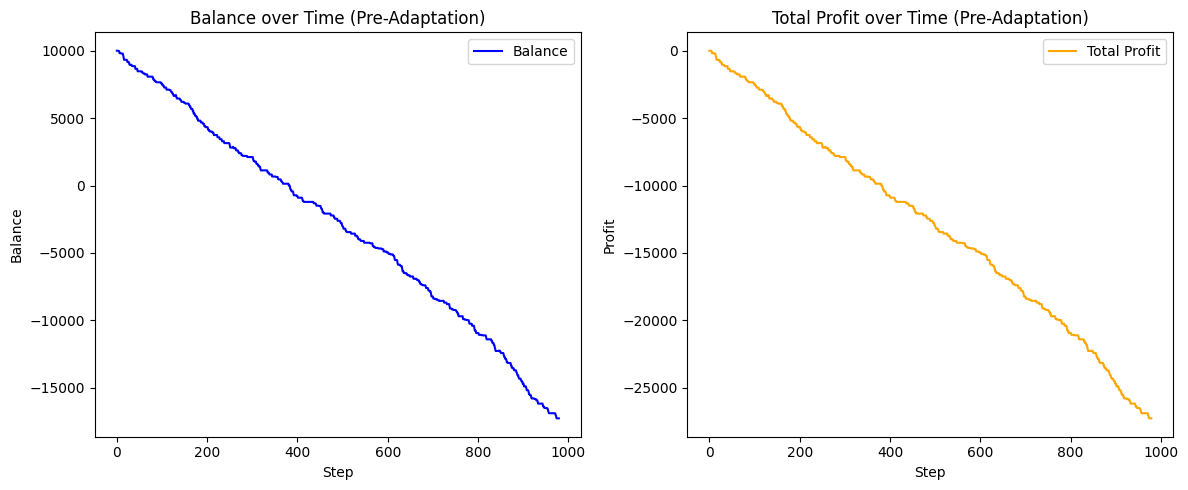

2025-02-19 19:15:38,250 INFO: Performing meta-learning adaptation on new market conditions...
2025-02-19 19:15:38,252 INFO: Starting meta-learning adaptation on new market data...
2025-02-19 19:15:49,011 INFO: Meta-learning adaptation complete.


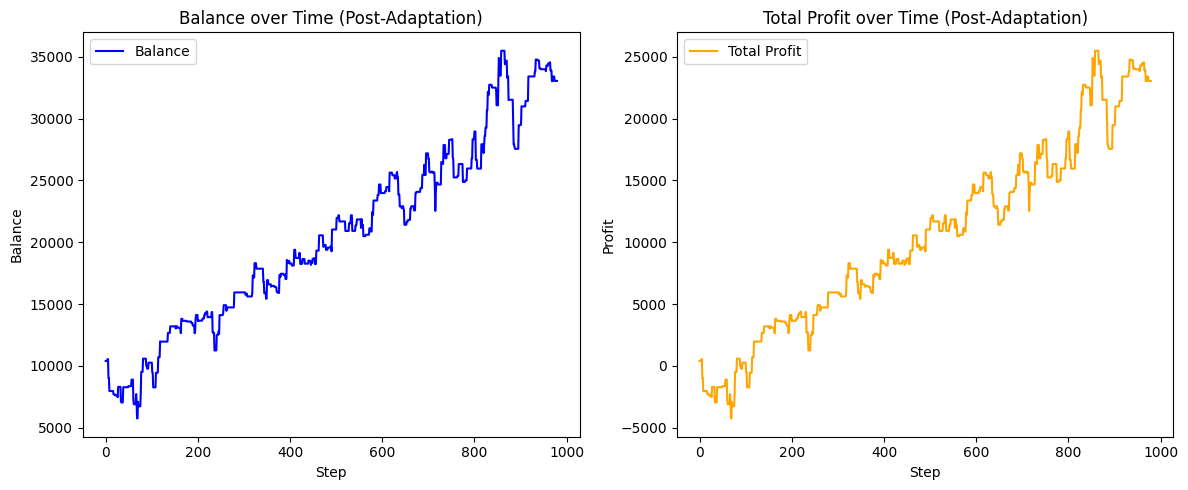

2025-02-19 19:15:51,469 INFO: Model saved as 'adaptive_trading_bot'
2025-02-19 19:15:51,470 INFO: Loading and using the saved model on a new dataset...
2025-02-19 19:15:51,471 INFO: Loading data from cache file: binance_data_new.csv


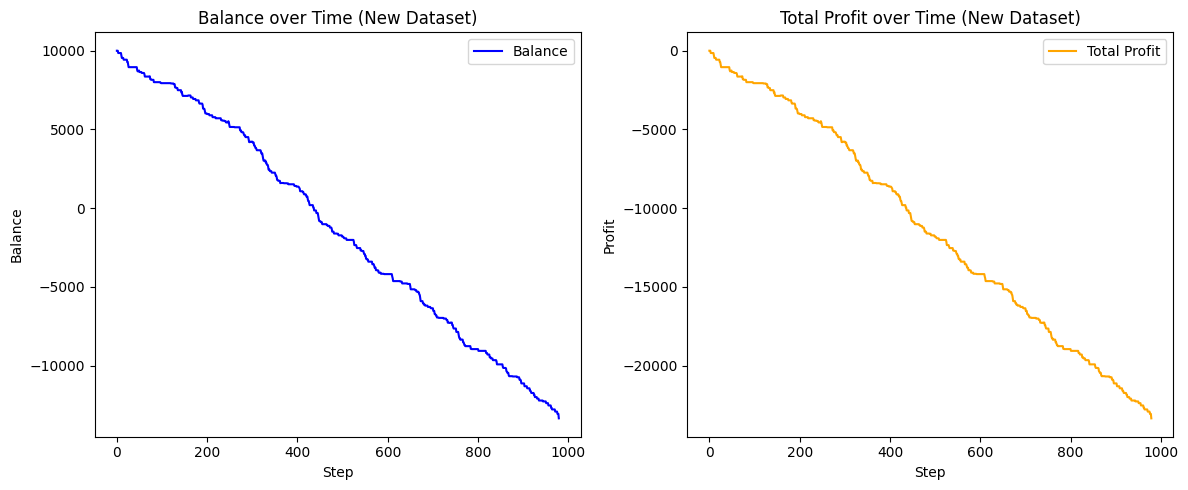

In [2]:
if __name__ == "__main__":
    main()